In [52]:
import json
import glob
import h_gen
import random
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import threading
import meta
import heatmap
metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras import callbacks
from keras.preprocessing.image import Iterator
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
import heatmap
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
from keras.models import load_model
from keras.models import model_from_json
from keras.layers.advanced_activations import LeakyReLU
import time
importlib.reload(utils)
importlib.reload(meta)
importlib.reload(h_gen)

<module 'h_gen' from 'C:\\Users\\yolo\\Desktop\\fish\\h_gen.py'>

In [2]:
image_size = (720,1280)
FOLDER_TRAIN = "temp_training/resnet/" # Intermediate vectors
SPLIT = 0.8 # For the train/test split

## First step, preprocess the data. Create train and test set.

In [8]:
# We need to make the network that process the data.
model1 = ResNet50(include_top=False, input_shape=(3,) + image_size)

In [9]:
model2 = Model(model1.input, model1.layers[-2].output)

img_a = Input(shape=(3,) + image_size)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
model = Model(img_a, x)

##### Let's do some precomputing:

In [24]:
X = np.zeros((1, 3)+image_size)
for key, v in metadata.items():
    
    # First of all, if there is no rectangle and the image is not in NoF, 
    # then there is a problem.

    if v["class"] != "NoF" and "rectangles" not in v:
        continue

    X[0] = img_to_array(load_img(v["path"],target_size=image_size))
    X = preprocess_input(X)
    y = model.predict(X)[0]
    utils.save_array(y, FOLDER_TRAIN + v["filename"])

In [10]:
# We also save the shape of the output mask
output_size = heatmap.get_dim(model, -1, input_shape=(3,)+image_size)
utils.save(output_size, FOLDER_TRAIN + "mask_size")

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpxf0cdbks/m9a6bd0eb5ed5c92e91261282fc495cb4.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpxf0cdbks/m9a6bd0eb5ed5c92e91261282fc495cb4.exp



In [3]:
output_size= utils.load(FOLDER_TRAIN + "mask_size")
nb_filters = output_size[0]
mask_size = output_size[1:]
print("size of our filters: " + str(nb_filters))
print("size of our mask: " + str(mask_size))

size of our filters: 2048
size of our mask: (23, 40)


In [4]:
list_files = h_gen.get_all_images(regex=FOLDER_TRAIN + "*.npy")
list_files = [x.split("/")[-1][:-4] for x in list_files]

random.shuffle(list_files)
l = int(0.8 * len(list_files))

training_set = list_files[:l]
test_set = list_files[l:]
print("First element for debug: " + training_set[0])

First element for debug: img_04413.jpg


## Second step, create the data generator.

In [86]:
class DiskArrayIterator(Iterator):
    
    def __init__(self, batch_size, nb_filters, mask_size, folder, file_list, 
                 metadata, with_name = False, shuffle=False, seed=None):
        self.batch_size=batch_size
        self.nb_filters=nb_filters
        self.mask_size=mask_size
        self.folder=folder
        self.file_list=file_list
        self.metadata = metadata
        self.with_name = with_name
        super(DiskArrayIterator, self).__init__(len(file_list), batch_size, shuffle, seed)
    
    
    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        
        reshaped = self.mask_size[0]*self.mask_size[1]
    
        X = np.zeros((self.batch_size, self.nb_filters) + self.mask_size)
        Y = [np.zeros((self.batch_size, reshaped,1)) for _ in range(5)]
        W = [np.zeros((self.batch_size, reshaped))   for _ in range(5)]
        
        selected_files = [self.file_list[i] for i in index_array]
        meta = [metadata[x] for x in selected_files]
        
        # We loop over the files
        for c, v in enumerate(meta):
            
            masks, m_weights = h_gen.get_5_masks_w(v, self.mask_size)
            
            m_weights = np.expand_dims(m_weights, axis=0)
            m_weights = np.reshape(m_weights,(reshaped,))
            
            # loop over the 5 masks
            for i, mask in enumerate(masks):
                
                mask0 = np.expand_dims(mask, axis=0)
                mask0 = np.reshape(mask0,(reshaped,))
                y = np.expand_dims(mask0, axis=1)

                X[c] = utils.load_array(self.folder + v["filename"])
                Y[i][c] = y
                W[i][c] = m_weights
        
        if self.with_name:
            return X, Y, W, [v["path"] for v in meta]
        return X, Y, W
        #return X, Y

In [5]:
def img_mask_generator(batch_size, nb_filters, mask_size, folder, file_list):
    reshaped = mask_size[0]*mask_size[1]
    
    X = np.zeros((batch_size, nb_filters)+mask_size)
    Y = [np.zeros((batch_size, reshaped,1)) for _ in range(5)]
    W = [np.zeros((batch_size, reshaped))   for _ in range(5)]
    
    
    while True:

        selected_files = random.sample(file_list, batch_size)
        meta = [metadata[x] for x in selected_files]
        
        # We loop over the files
        for c, v in enumerate(meta):
            
            masks, m_weights = h_gen.get_5_masks_w(v, mask_size)
            
            m_weights = np.expand_dims(m_weights, axis=0)
            m_weights = np.reshape(m_weights,(reshaped,))
            
            # loop over the 5 masks
            for i, mask in enumerate(masks):
                
                mask0 = np.expand_dims(mask, axis=0)
                mask0 = np.reshape(mask0,(reshaped,))
                y = np.expand_dims(mask0, axis=1)

                X[c] = utils.load_array(folder + v["filename"])
                Y[i][c] = y
                W[i][c] = m_weights

        yield X, Y, W
            

In [56]:
for X, Y, W in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata):
    break

In [57]:
print("shape of X:", X.shape)
print("lenght of Y:", len(Y))
print("shape of Y[0]:", Y[0].shape)
print("lenght of W:", len(W))
print("shape of W[0]:", W[0].shape)

shape of X: (16, 2048, 23, 40)
lenght of Y: 5
shape of Y[0]: (16, 920, 1)
lenght of W: 5
shape of W[0]: (16, 920)


In [58]:
train_gen = DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata)
test_gen = DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata)

## Third step, create the network.

##### First, let's create the network that will be shared:

In [39]:
nb_input_filters = 1000

# We put this value so that we can reuse the weights of the final layer of the resnet.

In [40]:
def create_separate_models(nb_input_filters, mask_size):

    img_a = Input(shape=(nb_input_filters,) + mask_size)

    x = Convolution2D(512, 1, 1, activation='relu')(img_a)
    x = Convolution2D(256, 1, 1, activation='relu')(x)
    x = Convolution2D(128, 1, 1, activation='relu')(x)
    x = Convolution2D(32, 1, 1, activation='relu')(x)
    x = Convolution2D(16, 1, 1, activation='relu')(x)
    x = Convolution2D(1, 1, 1, activation='linear')(x)
    #x = LeakyReLU(alpha=0.3)(x)
    x = Reshape((1, mask_size[0]*mask_size[1]))(x)
    x = Permute((2, 1))(x)

    return Model(img_a, x)

##### Here is the final network:

In [41]:
img_a = Input(shape=(nb_filters,) + mask_size)
x = Convolution2D(nb_input_filters, 1, 1, activation='relu')(img_a)

# We have 5 distincts models. The weights are not shared.
outputs = [create_separate_models(nb_input_filters, mask_size)(x) for _ in range(5)]

model = Model(img_a, outputs)

##### Let's insert the imageNet weights:

In [43]:
# We need the last weights of the resnet50:
resnet = ResNet50()

In [49]:
model.layers[1]

In [46]:
resnet.layers[-1]

In [50]:
heatmap.insert_weights(resnet.layers[-1], model.layers[1])

In [59]:
model_file = "models/resnet_mask_training.h5"

In [51]:
# we can now save the model.
model.save(model_file)

## Fourth step, training.

In [60]:
model = load_model(model_file)

C:\Program Files\Anaconda3\lib\site-packages\keras\models.py:148: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [65]:
model.layers[1].trainable=True

In [62]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.0, nesterov=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', optimizer="adam", sample_weight_mode="temporal")

In [66]:
history = model.fit_generator(train_gen, samples_per_epoch=16, nb_epoch=50, callbacks=[remote], 
                              verbose=0,validation_data=test_gen, nb_val_samples=32)
# 

In [93]:
file_trained = "models/fish_detection_trained.h5"

In [92]:
model.save(file_trained)

## Fifth step, display results.

In [ ]:
model = load_model(file_trained)

In [118]:
for X, Y, W , paths in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, training_set, metadata, with_name=True, seed=6):
    break

In [119]:
Z = model.predict(X)

./train/ALB/img_03642.jpg


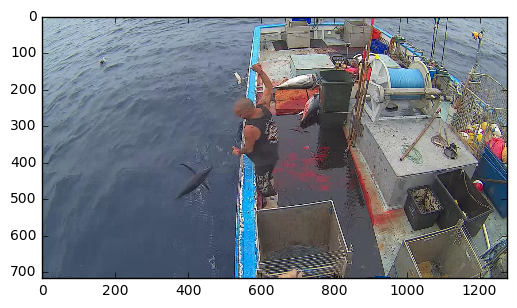

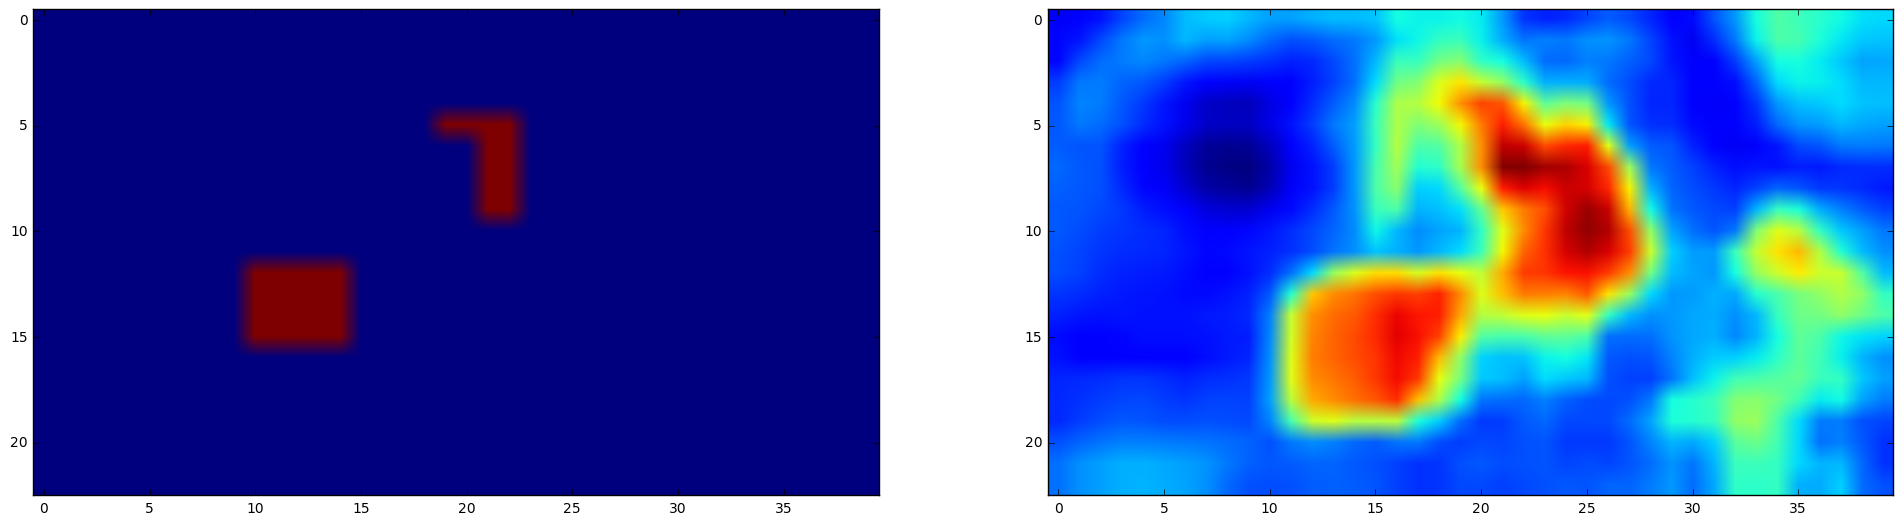

max:  0.845462


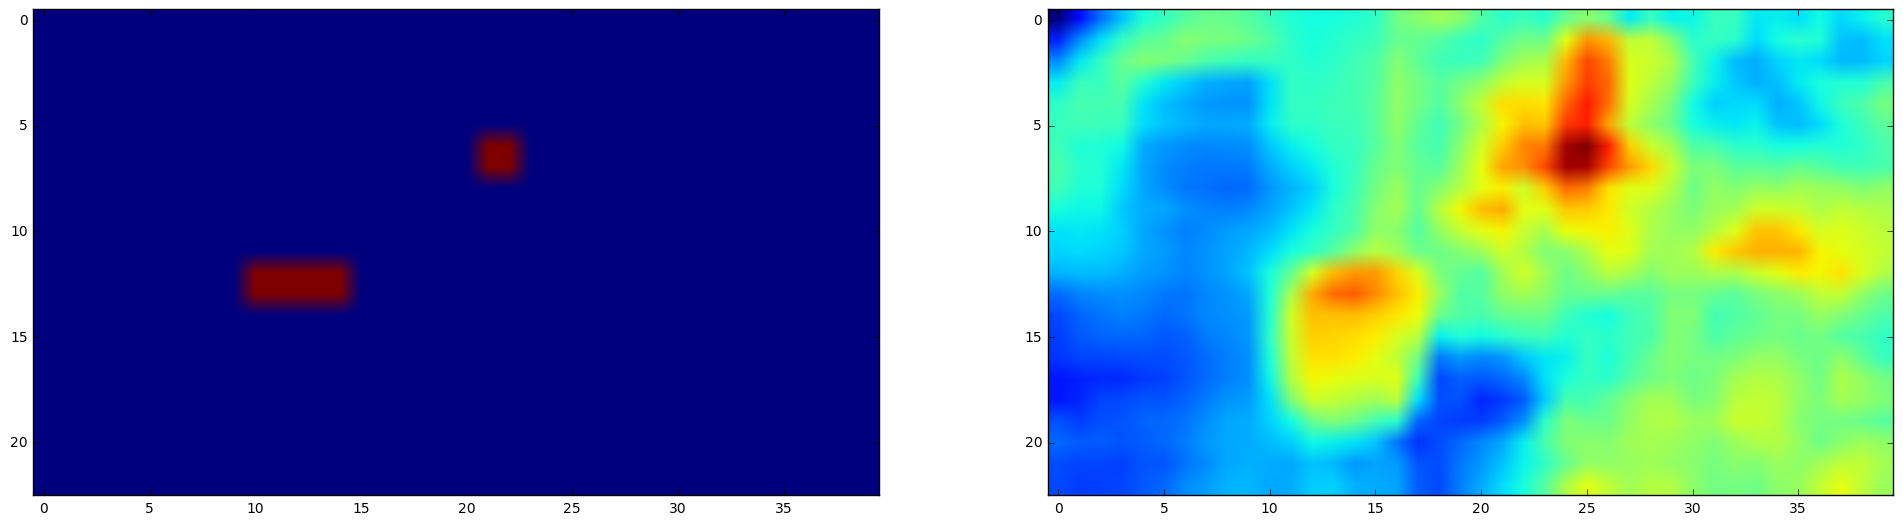

max:  0.423862


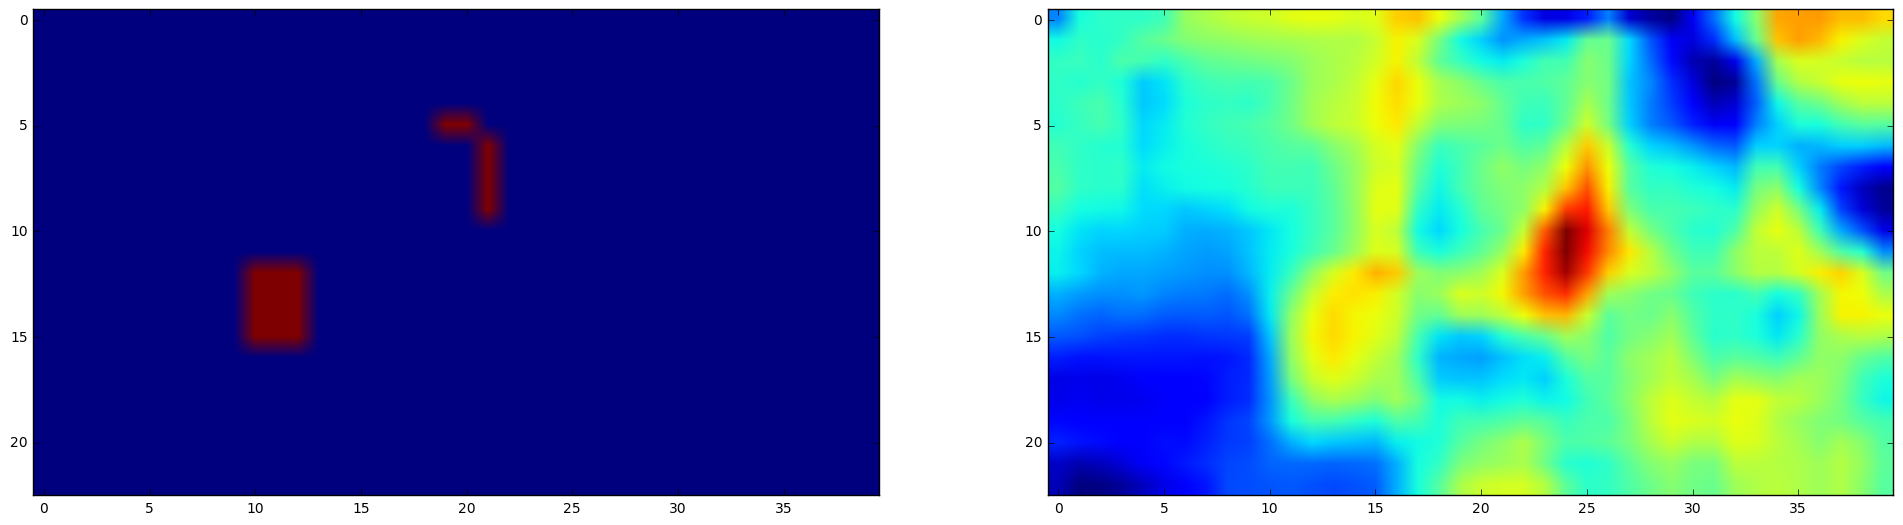

max:  0.293736


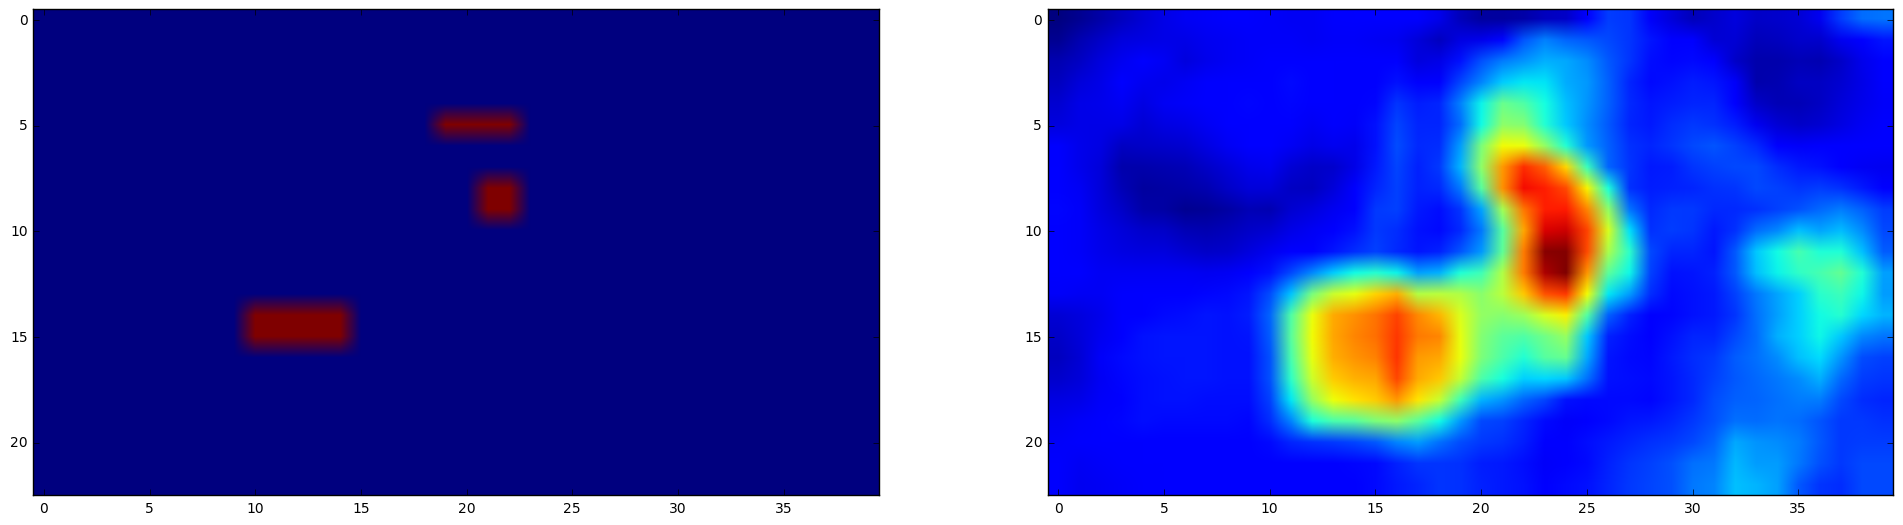

max:  0.794537


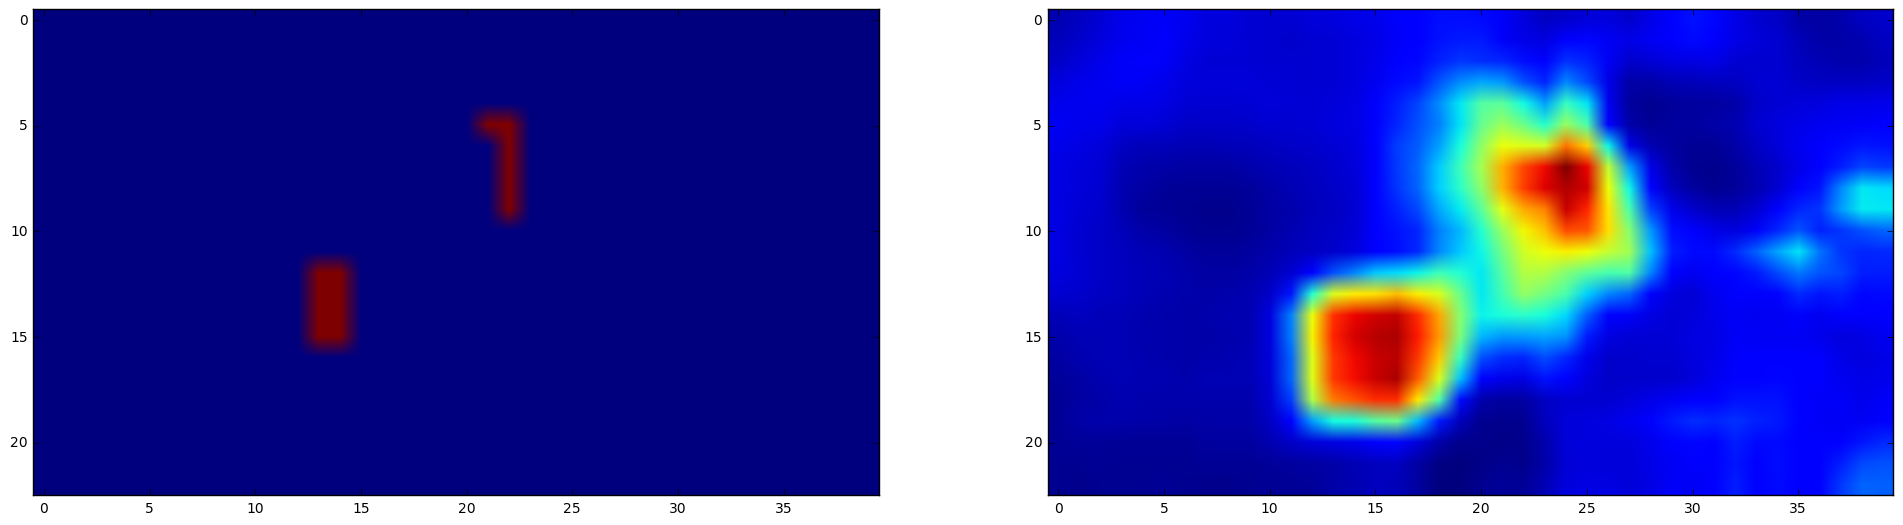

max:  0.742039


In [122]:
for i in range(4,5):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size))
        plt.show()
        print("max: ", np.max(Z[j][i]))

In [123]:
for X, Y, W , paths in DiskArrayIterator(16, nb_filters, mask_size, FOLDER_TRAIN, test_set, metadata, with_name=True, shuffle=True):
    break

In [124]:
Z = model.predict(X)

./train/OTHER/img_03022.jpg


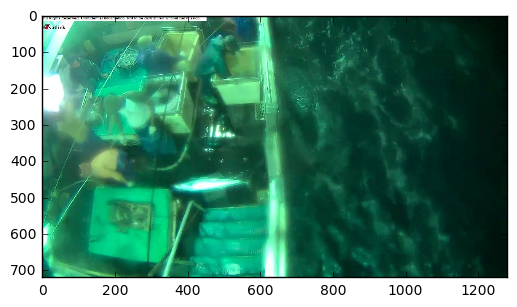

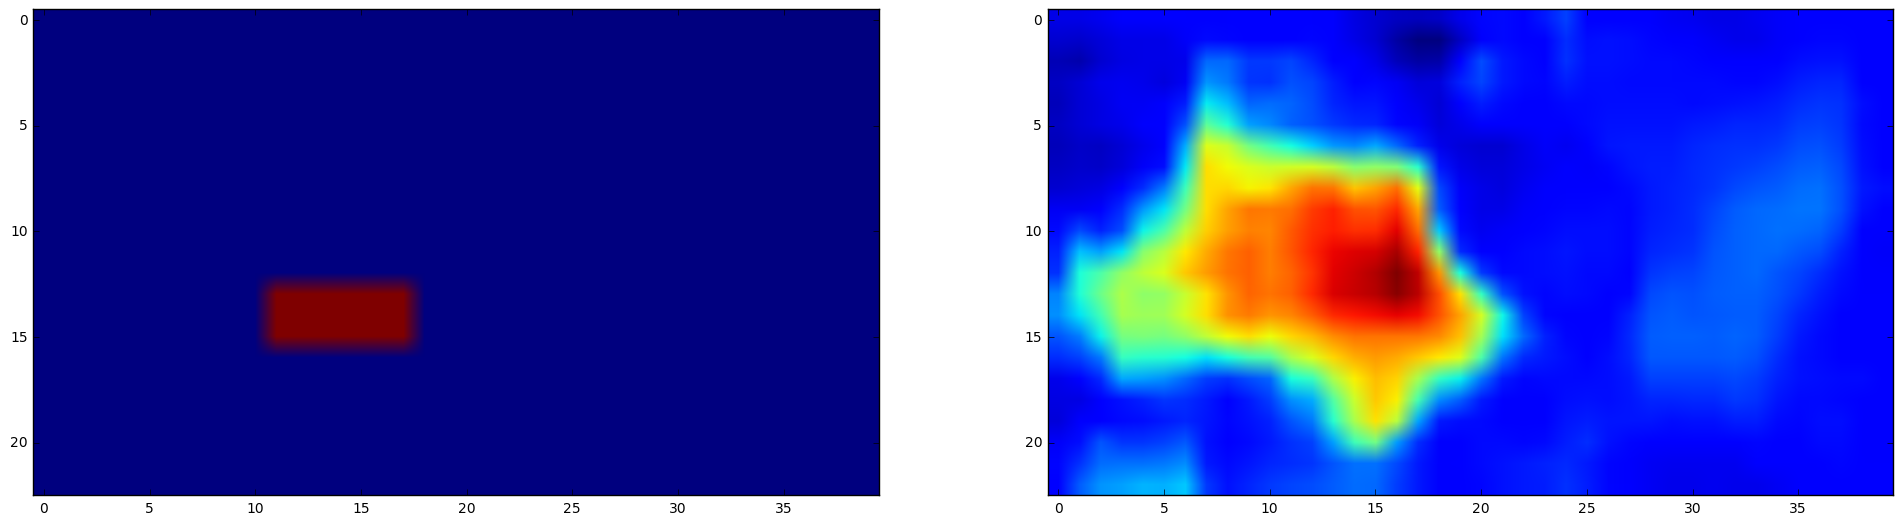

max:  1.23159


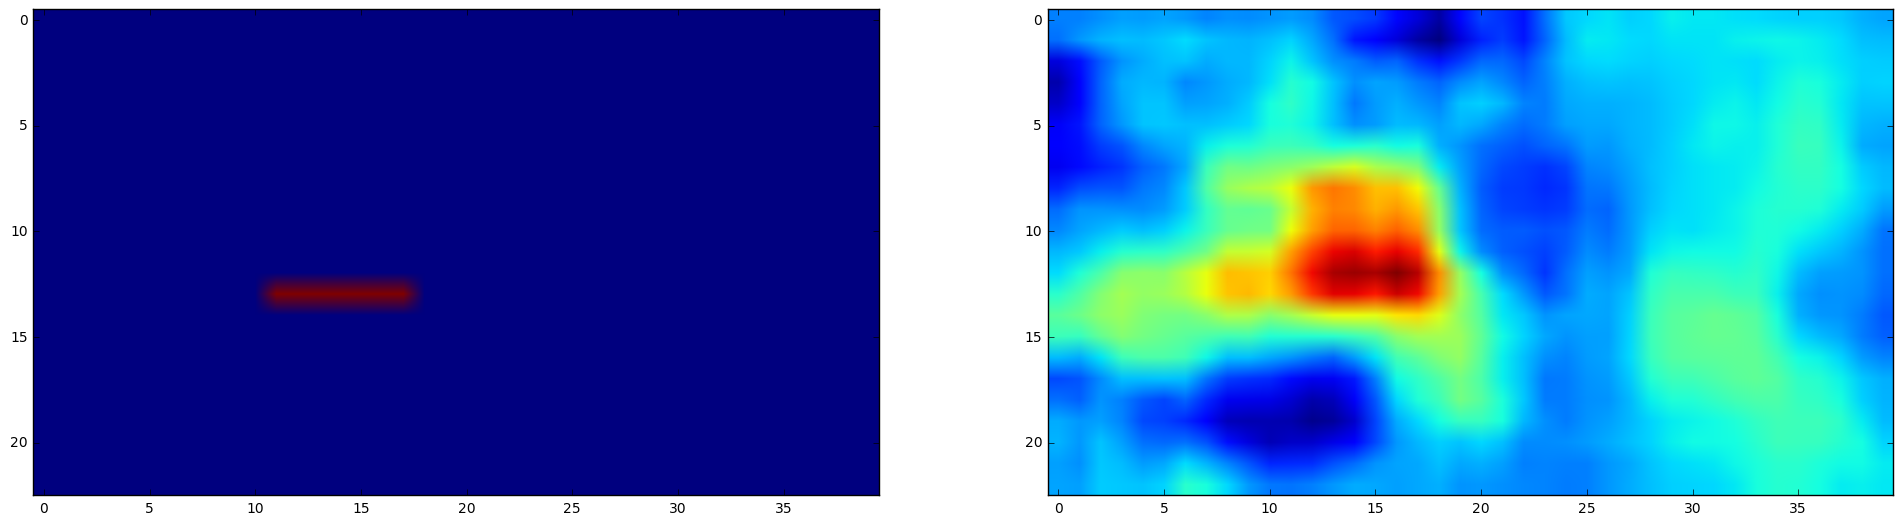

max:  0.689573


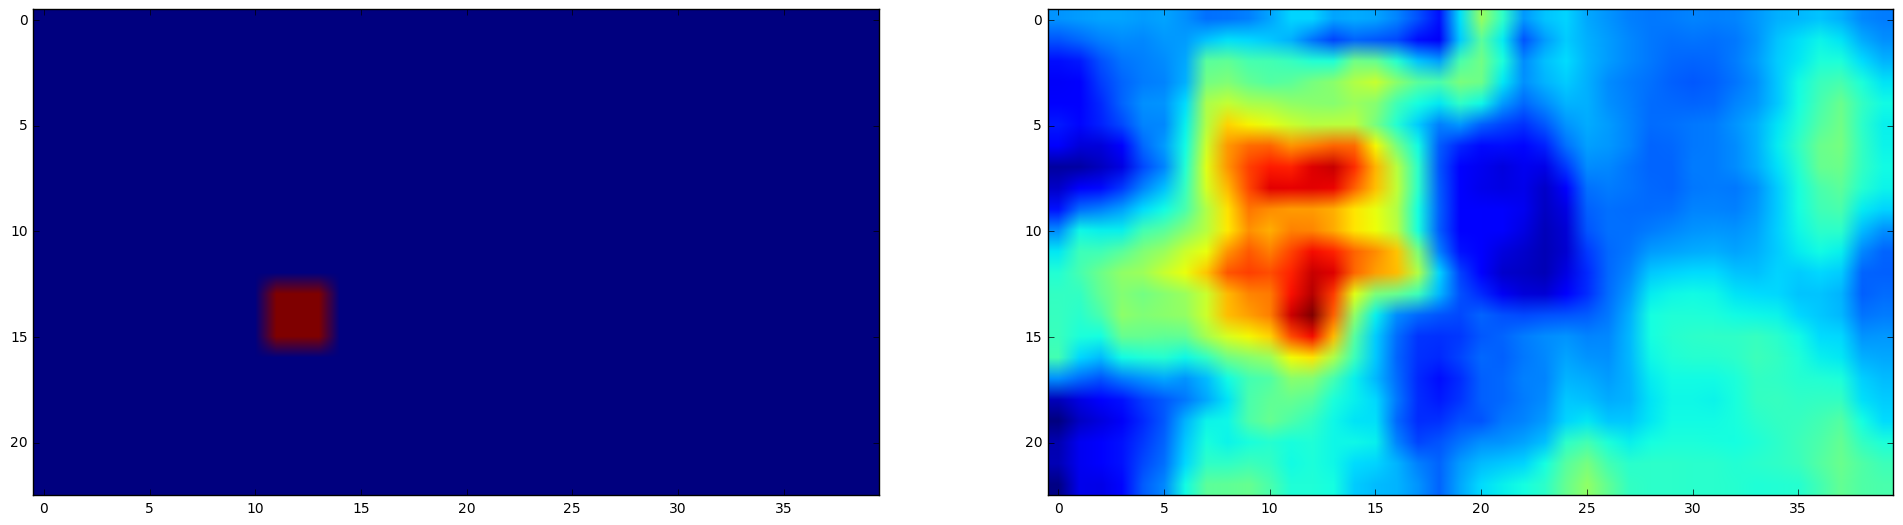

max:  0.430657


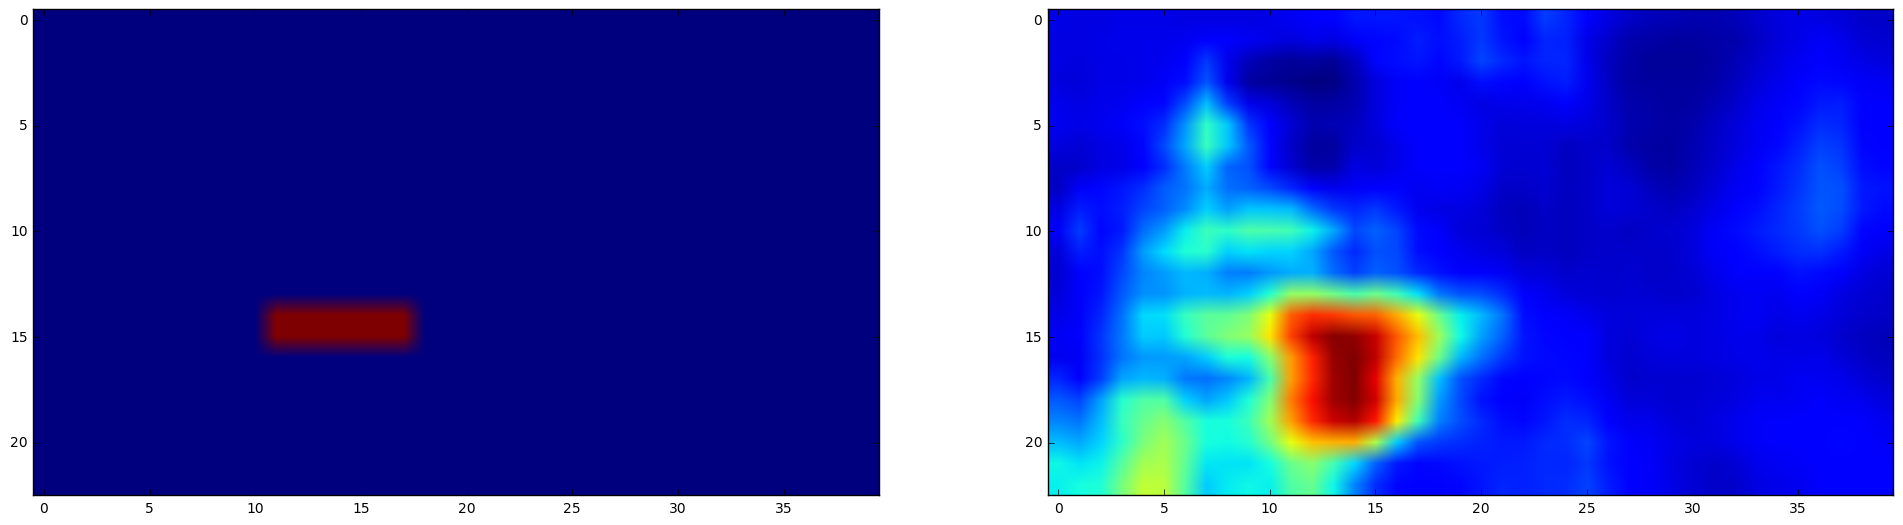

max:  0.82991


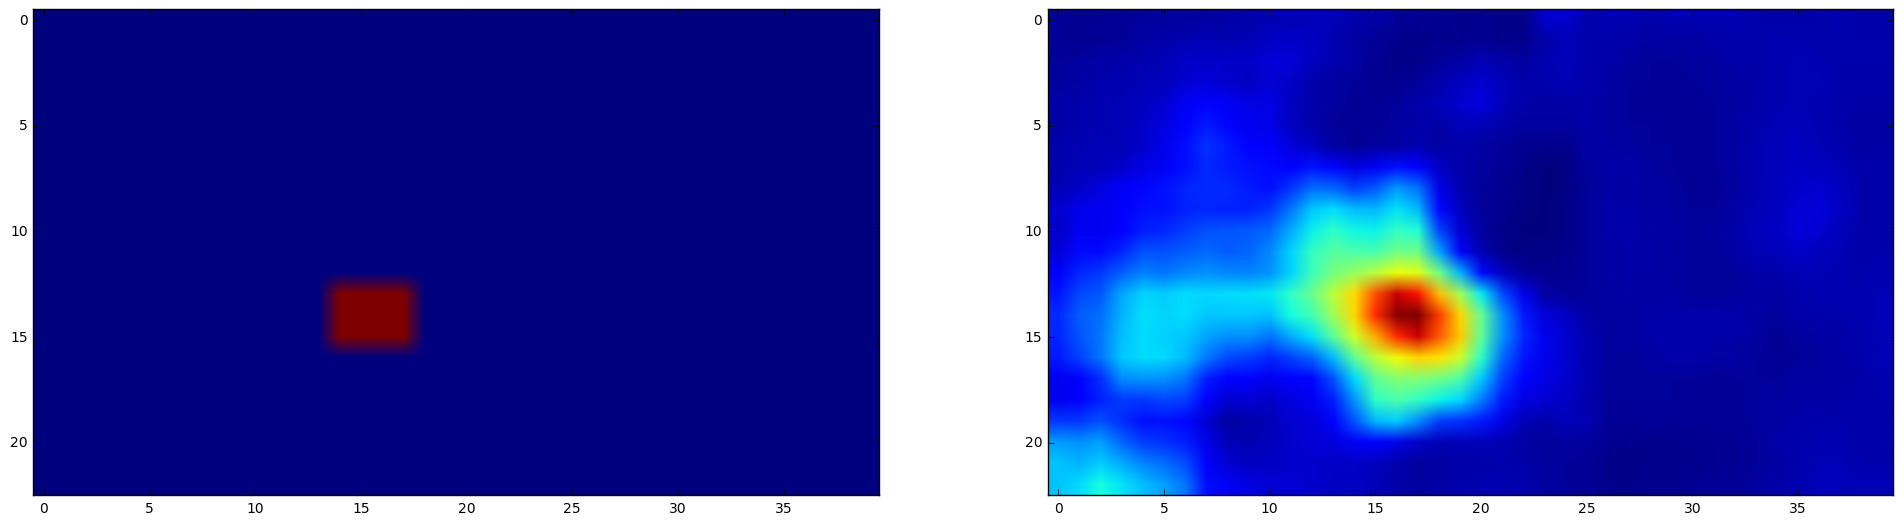

max:  1.11638


In [125]:
for i in range(1):
    print(paths[i])
    plt.imshow(load_img(paths[i]))
    plt.show()
    for j in range(5):
        plt.figure(figsize=(24,24))
        plt.subplot(1,2,1)
        plt.imshow(np.reshape(Y[j][i],mask_size))
        plt.subplot(1,2,2)
        plt.imshow(np.reshape(Z[j][i],mask_size))
        plt.show()
        print("max: ", np.max(Z[j][i]))

In [4]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10):
    reshaped = mask_size[0]*mask_size[1]
    
    X = np.zeros((batch_size, 3)+image_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    while True:
        c=0
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            mask0 = np.expand_dims(h_gen.get_mask(v, mask_size), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            
            y = np.expand_dims(mask0, axis=1)

            X[c] = img_to_array(load_img(v["path"],target_size=image_size))
            Y[c] = y
            W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W
            

In [2]:
batch_size = 2
image_size = (720,1280)
lambda_ratio = 20

for X, Y, W in img_mask_generator(batch_size, image_size,(100,100), lambda_ratio):
    break

NameError: name 'img_mask_generator' is not defined

In [8]:
batch_size = 2

lambda_ratio = 20

In [ ]:
model1 = ResNet50(include_top=False)
for layer in model1.layers:
    layer.trainable=False

In [5]:
model1 = heatmap.to_heatmap(model1)

Model type detected: local pooling - flatten
Model cut at layer: 18
Pool size infered: 7


In [6]:
for layer in model1.layers:
    layer.trainable=False

In [7]:
model1.layers[-2]

In [8]:
a,b,c = heatmap.get_dim(model1,-2, input_shape=(3,) + image_size)

In [9]:
b,c

(23, 40)

In [10]:
a

2048

In [5]:
mask_size = (23, 40)

In [12]:
mask_size = (b,c)

In [15]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [14]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, None, None) 0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, None, None 9472        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 64, None, None 256         conv1[0][0]                      
___________________________________________________________________________________________

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 3, 720, 1280)  0                                            
____________________________________________________________________________________________________
model_5 (Model)                  multiple              23587712    input_4[0][0]                    
____________________________________________________________________________________________________
averagepooling2d_3 (AveragePooli (None, 2048, 23, 40)  0           model_5[1][0]                    
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 1024, 23, 40)  2098176     averagepooling2d_3[0][0]         
___________________________________________________________________________________________

In [17]:
sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [19]:
history = model.fit_generator(img_mask_generator(batch_size, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=8, nb_epoch=500, callbacks=[remote], verbose=0)

In [ ]:
for X, Y, W in img_mask_generator(batch_size, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

In [ ]:
plt.imshow(array_to_img(X[0]))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Y[0],(c,b)),0,1))
plt.show()
plt.imshow(np.swapaxes(np.reshape(Z[0],(c,b)),0,1) - np.min(Z[0]))
plt.show()
a = Z[0]
idx = Z[0][:,:] > 1
a[idx] = 1
idx = Z[0][:,:] < 0
a[idx] = 0 
plt.imshow(np.swapaxes(np.reshape(a,(c,b)),0,1))
plt.show()


In [ ]:
np.max(Z[0])

In [ ]:
np.min(Z[0])

In [6]:
img_a = Input(shape=(3,) + image_size)
model2 = Model(model1.input, model1.layers[-2].output)
x = model2(img_a)
x = AveragePooling2D(pool_size=(7, 7), strides=(1,1), border_mode="same")(x)
model = Model(img_a,x)

In [14]:
X = np.zeros((1, 3)+image_size)
for key, v in metadata.items():
    
    # First of all, if there is no rectangle and the image is not in NoF, 
    # then there is a problem.

    if v["class"] != "NoF" and "rectangles" not in v:
        continue

    #X[0] = img_to_array(load_img(v["path"],target_size=image_size))
    #y = model.predict(X)[0]
    y = utils.load("out_resnet/" + v["filename"])
    utils.save_array(y, "out_resnet/bco/" + v["filename"])

In [3]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    Y = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    #Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                buffer_count+=1
            
            X[c] = x
            Y[c] = x
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y
                #yield X, Y, W
        print(time.time() - t)

In [6]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(1024, 1, 1, activation='relu')(x)
x = Convolution2D(2048, 1, 1, activation='linear')(x)
model = Model(img_a,x)

In [22]:
sgd = SGD(lr=15, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [23]:
history = model.fit_generator(img_mask_generator(32, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

KeyboardInterrupt: 

In [30]:
def img_mask_generator(batch_size=32, image_size = (224,224),mask_size=(100,100), lambda_ratio=10, buffer_size=100):
    reshaped = mask_size[0]*mask_size[1]
    buffer = np.zeros((buffer_size, 2048) + mask_size)
    buffer_names = {}
    X = np.zeros((batch_size, 2048) + mask_size)
    #X = np.ones((batch_size, 1)+mask_size)
    #Y = np.zeros((batch_size, mask_size[0]*mask_size[1], 2))
    Y = np.zeros((batch_size, reshaped,1))
    W = np.zeros((batch_size, reshaped))
    buffer_count = 0
    while True:
        c=0
        t = time.time()
        for key, v in metadata.items():
            
            # First of all, if there is no rectangle and the image is not in NoF, 
            # then there is a problem.
            
            if v["class"] != "NoF" and "rectangles" not in v:
                continue
            """mask0 = np.expand_dims(h_gen.get_mask(v, mask_size[::-1]), axis=0)
            mask0 = np.reshape(mask0,(reshaped,))
            #print(v["class"], v["filename"])
            y = np.expand_dims(mask0, axis=1)"""
            try:
                idx = buffer_names[v["filename"]]
                x = buffer[idx]
            except KeyError:
                x = utils.load_array("out_resnet/bco/" + v["filename"])
            
            if buffer_count < buffer_size:
                buffer[buffer_count] = x
                buffer_names[v["filename"]] = buffer_count
                #buffer_count+=1
            
            X[c] = x
            #Y[c] = y
            #W[c] = mask0*(lambda_ratio-1) + np.ones(mask0.shape)
            c+=1
            
            if c == batch_size:
                c = 0 
                yield X, Y, W
        print(time.time() - t)

In [17]:
for X, Y, W in img_mask_generator(8, image_size,mask_size, lambda_ratio):
    Z = model.predict(X)
    break

OTHER img_00639.jpg
ALB img_00337.jpg
ALB img_04354.jpg
ALB img_00843.jpg
ALB img_00895.jpg
YFT img_03657.jpg
BET img_00531.jpg
YFT img_04768.jpg


In [3]:
mask_size = (23,40)

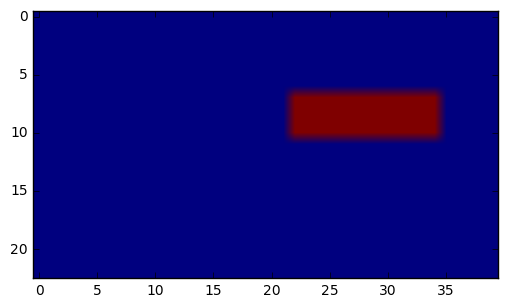

max: 1.3721
min: -0.271273
loss= 1.06143804633


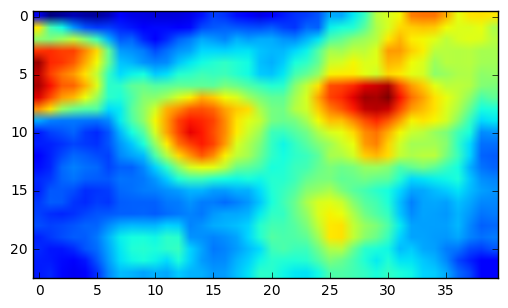

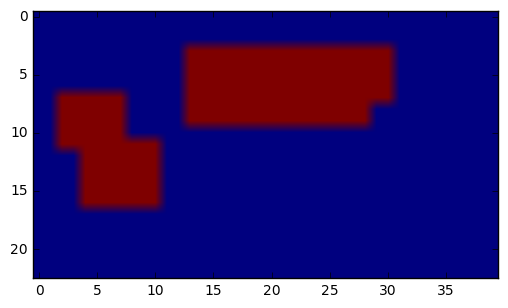

max: 1.38715
min: -0.112199
loss= 1.377212013


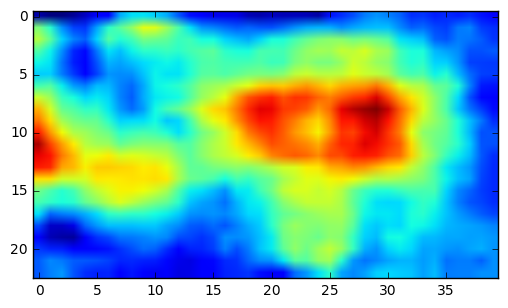

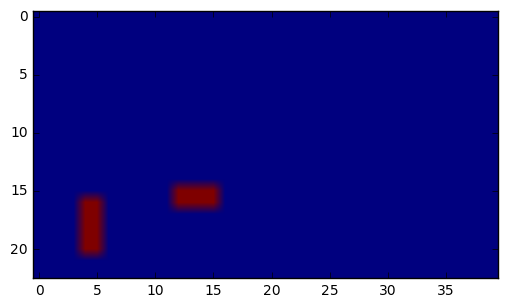

max: 0.864216
min: -0.428259
loss= 1.15179383302


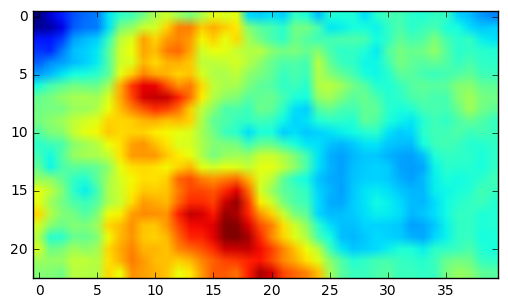

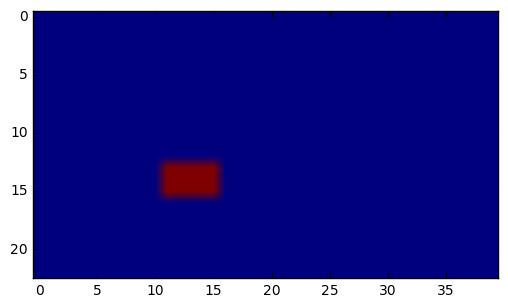

max: 1.18208
min: -0.310913
loss= 1.01826486313


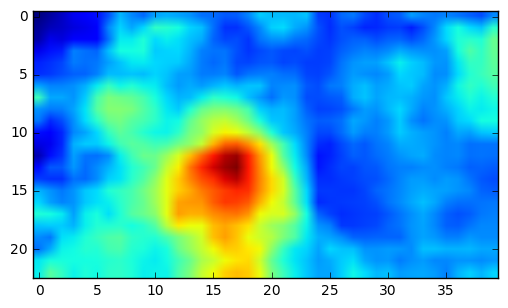

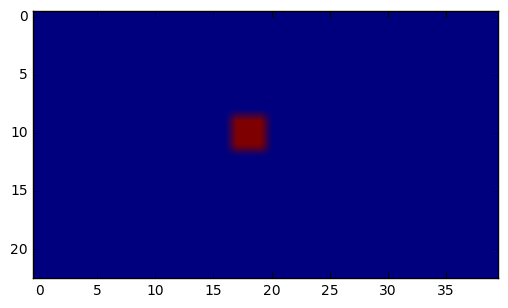

max: 0.568072
min: -0.171796
loss= 1.08326879306


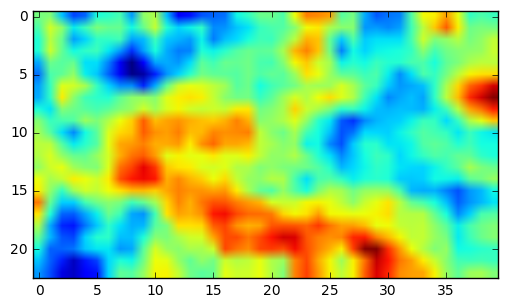

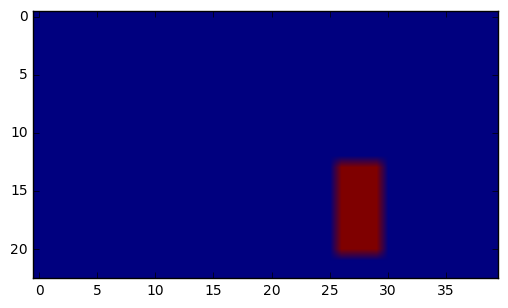

max: 1.28679
min: -0.220496
loss= 1.02356091


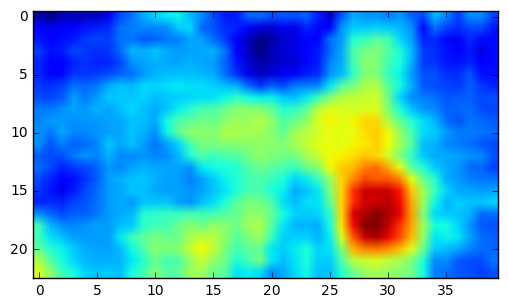

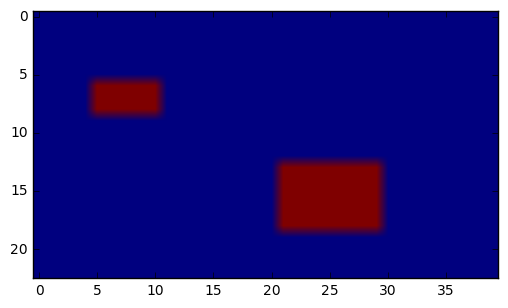

max: 1.46459
min: -0.12206
loss= 1.26169786743


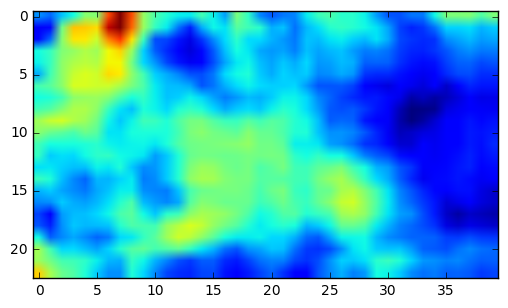

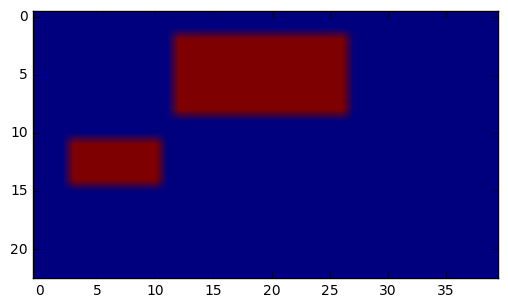

max: 1.55127
min: -0.345367
loss= 1.35726056917


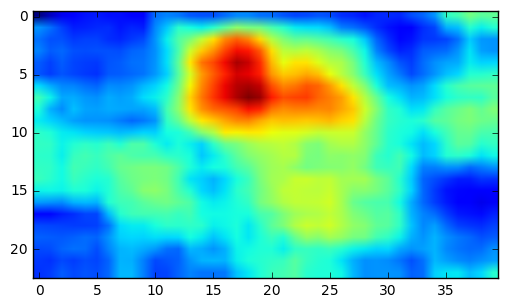

In [25]:
for i in range(0,8):
    plt.imshow(np.reshape(Y[i],(b,c)))
    plt.show()
    print("max: " + str(np.max(Z[i])))
    print("min: " + str(np.min(Z[i])))
    print("loss= " + str(np.sum(np.square(Y[i]-Z[i])*Y[i]*(lambda_ratio-1) + np.ones(Y[i].shape))/(23*40)))
    plt.imshow(np.reshape(Z[i],(b,c)))
    plt.show()

In [42]:
np.min(Z)

-0.21663238

In [16]:
mask_size = (23,40)

In [4]:
b,c = 23,40

In [5]:
img_a = Input(shape=(2048,) + mask_size)
x = Convolution2D(1024, 1, 1, activation='relu')(img_a)
x = Convolution2D(512, 1, 1, activation='relu')(x)
x = Convolution2D(256, 1, 1, activation='relu')(x)
x = Convolution2D(128, 1, 1, activation='relu')(x)
x = Convolution2D(32, 1, 1, activation='relu')(x)
x = Convolution2D(16, 1, 1, activation='relu')(x)
x = Convolution2D(1, 1, 1, activation='linear')(x)
#x = LeakyReLU(alpha=0.3)(x)
x = Reshape((1, b*c))(x)
x = Permute((2, 1))(x)
model = Model(img_a,x)

In [6]:
sgd = SGD(lr=0.001, decay=0.001, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [31]:
history = model.fit_generator(img_mask_generator(64, image_size,mask_size, lambda_ratio), 
                    samples_per_epoch=128, nb_epoch=5000, callbacks=[remote], verbose=0)

95.08838605880737
30.652315616607666


KeyboardInterrupt: 

In [47]:
np.sum(Z[0])

362.47931

In [280]:
np.all(np.equal(Y[0], Z[0]))

False

In [295]:
np.sum(Z[0])

3778.229

In [282]:
img_input = Input(shape=(1,100,100))
x = Convolution2D(1, 1, 1, border_mode="same")(img_input)
#x = Permute((1,2))(x)
#x = Permute((1,3))(x)
x = Reshape((1, 100*100))(x)
x = Permute((2, 1))(x)
#x = heatmap.Softmax4D(axis=1,name="softmax")(x)
model = Model(img_input,x)

In [283]:
model.layers[1].trainable = True

In [284]:
a = model.layers[1].get_weights()

In [285]:
a[1][0] = 0

In [286]:
a[0][0,0,0,0] = 1

In [287]:
model.layers[1].set_weights(a)

In [288]:
model.layers[1].get_weights()

[array([[[[ 1.]]]], dtype=float32), array([ 0.], dtype=float32)]

In [289]:
model.layers[1].get_config()

{'W_constraint': None,
 'W_regularizer': None,
 'activation': 'linear',
 'activity_regularizer': None,
 'b_constraint': None,
 'b_regularizer': None,
 'bias': True,
 'border_mode': 'same',
 'dim_ordering': 'th',
 'init': 'glorot_uniform',
 'name': 'convolution2d_16',
 'nb_col': 1,
 'nb_filter': 1,
 'nb_row': 1,
 'subsample': (1, 1),
 'trainable': True}

In [290]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 1, 100, 100)   0                                            
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 1, 100, 100)   2           input_16[0][0]                   
____________________________________________________________________________________________________
reshape_13 (Reshape)             (None, 1, 10000)      0           convolution2d_16[0][0]           
____________________________________________________________________________________________________
permute_13 (Permute)             (None, 10000, 1)      0           reshape_13[0][0]                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_______________________________

In [291]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.0, nesterov=True)
model.compile(loss='mse', optimizer=sgd, sample_weight_mode="temporal")

In [292]:
model.fit_generator(img_mask_generator(batch_size=3000), samples_per_epoch=32, nb_epoch=20, callbacks=[remote], verbose=0)

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [293]:
Z = model.predict(X)

In [294]:
np.max(Z[0])

0.37782291